In [1]:
import HP_tuning as hp
import numpy as np
import matplotlib.pyplot as plt
import torch
from importlib import reload
import ActorCritic
import PolicyGradient
import gym

## Actor-Critic runs

In [2]:
list_of_steps = [1, 5, 10, 50]
common_dict = {
    'TD':True, 
    'twin':False, 
    'tau':1.0, 
    'hiddens': [32, 16],
    'lr':0.0025,
    'gamma':0.99,
    'device':'cpu'
}
list_of_models = [{'n_steps':n, **common_dict} for n in list_of_steps]

In [3]:
list_of_models.append({
    'TD':False, 
    'twin':False, 
    'tau':1.0, 
    'hiddens': [32, 16],
    'lr':0.0025,
    'gamma':0.99,
    'device':'cpu',
    'n_steps':1 #not used by MC
})

In [4]:
list_of_models

[{'n_steps': 1,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 5,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 10,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'n_steps': 50,
  'TD': True,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu'},
 {'TD': False,
  'twin': False,
  'tau': 1.0,
  'hiddens': [32, 16],
  'lr': 0.0025,
  'gamma': 0.99,
  'device': 'cpu',
  'n_steps': 1}]

In [ ]:
parent_dir = "Results/Final_Results/"
train = True
if train:
    save = True
    n_runs = 10
    n_episodes = 5000
    HP_scores, HP_asymptotic_score, HP_asymptotic_std = hp.HP_Search(n_runs, n_episodes, list_of_models, 
                                                                     shape_r=False, bootstrap_flag=True)

    if save:
        
        np.save(parent_dir+"model_scores", HP_scores)
        np.save(parent_dir+"model_asymptotic_score", HP_asymptotic_score)
        np.save(parent_dir+"model_asymptotic_std", HP_asymptotic_std)
        np.save(parent_dir+"list_of_models", list_of_models)


Evaluating HP 1 / 5... 

Run 1/10: 
Episode 100 - reward: 14
Episode 200 - reward: 9
Episode 300 - reward: 12
Episode 400 - reward: 22
Episode 500 - reward: 49
Episode 600 - reward: 63
Episode 700 - reward: 46
Episode 800 - reward: 151
Episode 900 - reward: 108
Episode 1000 - reward: 29
Episode 1100 - reward: 35
Episode 1200 - reward: 39
Episode 1300 - reward: 43
Episode 1400 - reward: 47
Episode 1500 - reward: 47
Episode 1600 - reward: 55
Episode 1700 - reward: 71
Episode 1800 - reward: 178
Episode 1900 - reward: 93
Episode 2000 - reward: 80
Episode 2100 - reward: 133
Episode 2200 - reward: 232
Episode 2300 - reward: 224
Episode 2400 - reward: 183
Episode 2500 - reward: 207
Episode 2600 - reward: 260
Episode 2700 - reward: 370
Episode 2800 - reward: 490
Episode 2900 - reward: 500
Episode 3000 - reward: 500
Episode 3100 - reward: 500
Episode 3200 - reward: 500
Episode 3300 - reward: 500
Episode 3400 - reward: 500
Episode 3500 - reward: 500
Episode 3600 - reward: 500
Episode 3700 - rew

Episode 800 - reward: 53
Episode 900 - reward: 36
Episode 1000 - reward: 33
Episode 1100 - reward: 39
Episode 1200 - reward: 48
Episode 1300 - reward: 59
Episode 1400 - reward: 80
Episode 1500 - reward: 200
Episode 1600 - reward: 22
Episode 1700 - reward: 30
Episode 1800 - reward: 40
Episode 1900 - reward: 46
Episode 2000 - reward: 64
Episode 2100 - reward: 83
Episode 2200 - reward: 124
Episode 2300 - reward: 173
Episode 2400 - reward: 222
Episode 2500 - reward: 375
Episode 2600 - reward: 488
Episode 2700 - reward: 491
Episode 2800 - reward: 498
Episode 2900 - reward: 495
Episode 3000 - reward: 498
Episode 3100 - reward: 500
Episode 3200 - reward: 500
Episode 3300 - reward: 500
Episode 3400 - reward: 500
Episode 3500 - reward: 500
Episode 3600 - reward: 500
Episode 3700 - reward: 500
Episode 3800 - reward: 500
Episode 3900 - reward: 500
Episode 4000 - reward: 500
Episode 4100 - reward: 500
Episode 4200 - reward: 500
Episode 4300 - reward: 500
Episode 4400 - reward: 500
Episode 4500 - r

Episode 100 - reward: 22
Episode 200 - reward: 28
Episode 300 - reward: 170
Episode 400 - reward: 159
Episode 500 - reward: 207
Episode 600 - reward: 217
Episode 700 - reward: 279
Episode 800 - reward: 386
Episode 900 - reward: 333
Episode 1000 - reward: 499
Episode 1100 - reward: 500
Episode 1200 - reward: 500
Episode 1300 - reward: 487
Episode 1400 - reward: 493
Episode 1500 - reward: 490
Episode 1600 - reward: 500
Episode 1700 - reward: 500
Episode 1800 - reward: 500
Episode 1900 - reward: 492
Episode 2000 - reward: 500
Episode 2100 - reward: 500
Episode 2200 - reward: 500
Episode 2300 - reward: 500
Episode 2400 - reward: 500
Episode 2500 - reward: 500
Episode 2600 - reward: 500
Episode 2700 - reward: 500
Episode 2800 - reward: 500
Episode 2900 - reward: 500
Episode 3000 - reward: 500
Episode 3100 - reward: 500
Episode 3200 - reward: 500
Episode 3300 - reward: 500
Episode 3400 - reward: 500
Episode 3500 - reward: 500
Episode 3600 - reward: 500
Episode 3700 - reward: 500
Episode 3800

Episode 500 - reward: 123
Episode 600 - reward: 177
Episode 700 - reward: 180
Episode 800 - reward: 251
Episode 900 - reward: 140
Episode 1000 - reward: 122
Episode 1100 - reward: 118
Episode 1200 - reward: 130
Episode 1300 - reward: 228
Episode 1400 - reward: 276
Episode 1500 - reward: 288
Episode 1600 - reward: 9
Episode 1700 - reward: 9
Episode 1800 - reward: 9
Episode 1900 - reward: 9
Episode 2000 - reward: 9
Episode 2100 - reward: 9
Episode 2200 - reward: 9
Episode 2300 - reward: 9
Episode 2400 - reward: 9
Episode 2500 - reward: 9
Episode 2600 - reward: 9
Episode 2700 - reward: 9
Episode 2800 - reward: 9
Episode 2900 - reward: 9
Episode 3000 - reward: 9
Episode 3100 - reward: 9
Episode 3200 - reward: 9
Episode 3300 - reward: 9
Episode 3400 - reward: 9
Episode 3500 - reward: 9
Episode 3600 - reward: 9
Episode 3700 - reward: 10
Episode 3800 - reward: 10
Episode 3900 - reward: 145
Episode 4000 - reward: 147
Episode 4100 - reward: 136
Episode 4200 - reward: 170
Episode 4300 - reward: 

Episode 4700 - reward: 500
Episode 4800 - reward: 500
Episode 4900 - reward: 500
Episode 5000 - reward: 500

Run 5/10: 
Episode 100 - reward: 29
Episode 200 - reward: 151
Episode 300 - reward: 173
Episode 400 - reward: 236
Episode 500 - reward: 221
Episode 600 - reward: 225
Episode 700 - reward: 249
Episode 800 - reward: 379
Episode 900 - reward: 471
Episode 1000 - reward: 497
Episode 1100 - reward: 500
Episode 1200 - reward: 497
Episode 1300 - reward: 500
Episode 1400 - reward: 500
Episode 1500 - reward: 500
Episode 1600 - reward: 500
Episode 1700 - reward: 500
Episode 1800 - reward: 500
Episode 1900 - reward: 500
Episode 2000 - reward: 500
Episode 2100 - reward: 500
Episode 2200 - reward: 496
Episode 2300 - reward: 500
Episode 2400 - reward: 500
Episode 2500 - reward: 500
Episode 2600 - reward: 500
Episode 2700 - reward: 500
Episode 2800 - reward: 500
Episode 2900 - reward: 500
Episode 3000 - reward: 500
Episode 3100 - reward: 500
Episode 3200 - reward: 500
Episode 3300 - reward: 500

In [11]:
HP_scores_b = np.load(parent_dir+"model_scores.npy")
HP_asymptotic_score_b = np.load(parent_dir+"model_asymptotic_score.npy")
HP_asymptotic_std_b = np.load(parent_dir+"model_asymptotic_std.npy")
list_of_dict_b = np.load(parent_dir+"list_of_models.npy", allow_pickle=True)

In [12]:
HP_scores_b.shape

(5, 10, 5000)

## REINFORCE run

In [ ]:
import time

In [ ]:
def play_episode(agent, env):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    steps = 0
    while True:
        steps += 1
        action, log_prob = agent.get_action(state, return_log = True)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal or steps > 500:
            break
            
        state = new_state
        
    rewards = np.array(rewards)
    done = np.array(done)
    return rewards, log_probs, done

In [ ]:
# copied from cartpole_task notebook

def train_cartpole(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = PolicyGradient.PolicyGrad(observation_space, action_space, lr, gamma, device='cuda')
    performance = []
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, _ = play_episode(agent, env)
        performance.append(np.sum(rewards))
        if (e+1)%100 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-100:])))
        
        loss = agent.update(rewards, log_probs)
        losses.append(loss)
    return agent, np.array(performance), np.array(losses)

In [ ]:
train = True
save = True
n_runs = 10
n_episodes = 5000
lr = 0.0025

if train:
    results_v0 = []
    for i in range(n_runs):
        start = time.time()
        print("\nRun %d/%d: "%(i+1, n_runs)) 
        trained_agentPG, cumulative_rewardPG, lossesPG = train_cartpole(n_episodes = n_episodes, lr=lr)
        results_v0.append(cumulative_rewardPG)
        run_time = time.time() - start
        print('Elapsed time: %.2f min'%(run_time/60))
REINFORCE_results = np.array(results_v0)
if save:
    np.save(parent_dir+"REINFORCE_scores", REINFORCE_results)

## Plots

In [16]:
REINFORCE_results.shape

(10, 5000)

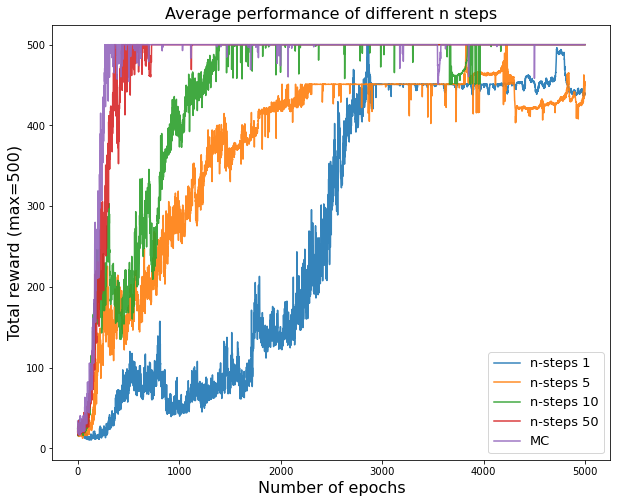

In [18]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_b.shape[2])
for i in range(len(HP_scores_b)):
    if list_of_dict_b[i]['TD'] == True:
        label = "n-steps %d"%list_of_dict_b[i]['n_steps']
    else:
        label = "MC"
    average = HP_scores_b[i].mean(axis=0)
    plt.plot(n_epochs, average, alpha=0.9, label=label)
plt.title("Average performance of different n steps", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()

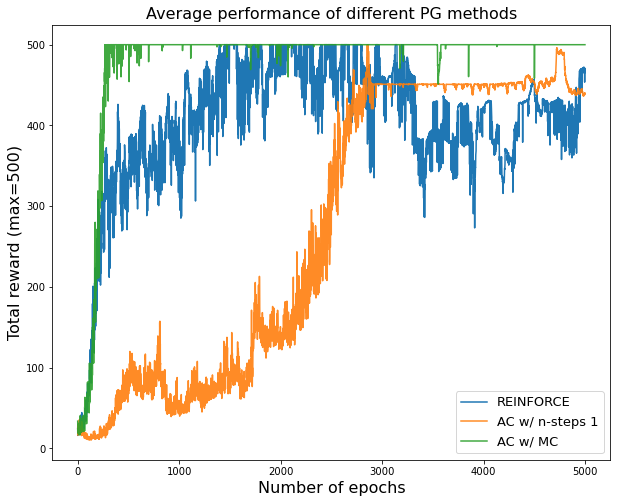

In [19]:
plt.figure(figsize=(10,8))
n_epochs = np.arange(HP_scores_b.shape[2])
plt.plot(n_epochs, REINFORCE_results.mean(axis=0), label='REINFORCE')
plt.plot(n_epochs, HP_scores_b[0].mean(axis=0), alpha=0.9, label='AC w/ n-steps 1')
plt.plot(n_epochs, HP_scores_b[-1].mean(axis=0), alpha=0.9, label='AC w/ MC')
plt.title("Average performance of different PG methods", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.legend(fontsize = 13)                                                        
plt.show()